# MUWCLASS Pipeline on CSCv2 Demonstration
## see our paper at https://arxiv.org/abs/2206.13656

### Hui Yang1, Jeremy Hare2, Oleg Kargaltsev1, Igor Volkov1
### 1 The George Washington University 2 NASA GSFC

### Contact huiyang@gwu.edu if you have any questions

This notebook presents a demonstration of classifying Chandra Source Catalog v2 (CSCv2) using the MUltiWavelength Machine Learning CLASSification Pipeline with CSCv2 and multiwavelength data

This notebook is available at https://github.com/huiyang-astro/MUWCLASS_CSCv2


* This notebook was run in CIAO 4.14 with Python 3.9 
* run the follow code to create a new conda environment ciao-4.14-muwclass; if you already have ciao-4.14 installed with Python 3.9, you can use your own conda environment with additional Python packages installed from below
* conda create -n ciao-4.14-muwclass -c https://cxc.cfa.harvard.edu/conda/ciao -c conda-forge ciao sherpa ds9 ciao-contrib caldb_main marx python=3.9


* run 'bash install-packages.sh' under ciao-4.14-muwclass environment to install all required packages 

* then, make sure to enable widgetsnbextension and ipyaladin, run
* jupyter nbextension enable --py widgetsnbextension
* jupyter nbextension enable --py --sys-prefix ipyaladin on your terminal

* You might also need to manually register the existing ds9 with the xapns name server by selecting the ds9 File->XPA->Connect menu option so your ds9 will be fully accessible to pyds9.


## Related Posters:

Machine Learning Classification of Variable Galactic X-ray Sources from Chandra Source Catalog
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=77

X-ray Source Populations in NGC 3532 and Other Intermediate Age Star Clusters
* https://submissions.mirasmart.com/HEAD19/itinerary/PresentationDetail.aspx?evdid=113

In [2]:
import numpy as np
import pandas as pd

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import astroquery
from astropy.table import QTable, Table
from astropy.io import fits
import pyvo as vo


import time
from pathlib import Path
import multiprocessing as mp

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
# import ipyaladin.aladin_widget as ipyal
import holoviews as hv
from bokeh.io import show
from bokeh.layouts import layout
import sklearn 

import sys  
sys.path.insert(0, '../')

from test_library     import  plot_confusion_matrix, plot_Feature_Importance_withSTD, class_train_model_and_classify
from muwclass_library import class_prepare, class_train_and_classify, class_save_res, col_rename, confident_flag, confident_sigma, find_confident, plot_classifier_matrix_withSTD, prepare_cols,class_prepare_oversample
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix, prepare_evts_plot_xray_class, interactive_Ximg_class, CMweight_probability
from prepare_library import CSCview_conesearch, get_rms_res


plt.rcParams.update({'font.size': 25})
params = {'legend.fontsize': 'large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

Some optional plots require the Chandra Interactive Analysis of Observations (CIAO) environment. If you want to use these features, set 'ciao' to True.

In [2]:
ciao = False
if ciao:
    import pyds9 as ds9

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
print("Versions:")
print(f"  NumPy       - {np.__version__}")
print(f"  Matplotlib  - {matplotlib.__version__}")
print(f"  AstroPy     - {astropy.__version__}")
print(f"  PyDS9       - {vo.__version__}")
print(f"  Astroquery  - {astroquery.__version__}")
print(f"  Seaborn     - {sns.__version__}")
print(f"  Holoviews     - {hv.__version__}")
print(f"  sklearn       - {sklearn.__version__}")

Versions:
  NumPy       - 1.21.5
  Matplotlib  - 3.5.1
  AstroPy     - 5.1
  PyDS9       - 1.3
  Astroquery  - 0.4.6
  Seaborn     - 0.11.2
  Holoviews     - 1.14.8
  sklearn       - 1.1.1


### workflow chart and the training dataset source breakdown of the MUWCLASS pipeline

In [4]:
display(Image(filename='../../files/figs/flowchart_TD_breakdown.png',width = 600))

The pipeline is configured to download and classify sources from the Chandra Source Catalog. 

If you want to classify sources not currently in the CSC, or if otherwise you want to use source properties from your own CXO analysis (or our CXO pipeline), set using_CXO = 'CXO'. Note that column names must be consistent with the format output by the CXO pipeline.

In [4]:
CSC_or_CXO = 'CXO'

## Using Sources from Chandra Source Catalog

#### Define a circular region of interest with detections available from CSCv2 (ACIS chips only)

* field_name
* RA, DEC, radius: RA (right ascension) and Dec (declination) coordinates and radius (in arcmin) of the field

In [5]:
# dictionary of cluster name and CSCview cone search parameters. Radius is in degrees
clusters_dict = {'NGC3532': {'ra': 166.28875, 'dec': -58.85, 'radius': 0.2, 'create_perobs': False},
'NGC3532_20': {'ra': 166.28875, 'dec': -58.85, 'radius': 0.2, 'create_perobs': False},
'Trumpler18': {'ra': 167.9712649, 'dec': -60.6184559, 'radius': 0.2},
'IC2395': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 0.2, 'create_perobs': True},
'IC2395_CXO': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 0.2, 'create_perobs': True},
'IC2395_CXO_noconversion': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 0.2, 'create_perobs': True},
'NGC2169': {'ra': 92.1011374, 'dec': 13.9711171, 'radius': 0.2, 'create_perobs': True},
'NGC2169_CXO': {'ra': 92.1011374, 'dec': 13.9711171, 'radius': 0.2, 'create_perobs': True},
}

# select cluster
field_name = 'IC2395_CXO_noconversion'
RA = clusters_dict[field_name]['ra']
DEC = clusters_dict[field_name]['dec']
radius = (clusters_dict[field_name]['radius']*u.deg).to(u.arcmin).value
create_perobs = clusters_dict[field_name]['create_perobs']


# creating the directories for saving the data and results 

data_dir = f'./data/{field_name}' # data directory to save the file

dir_out = f'./{field_name}_results' # classification results directory
dir_plot = dir_out+'/plot' # plots directory
Path(dir_out).mkdir(parents=True, exist_ok=True)
Path(dir_plot).mkdir(parents=True, exist_ok=True)


#### Cone search -- new version using CSCview_conesearch function

* search_engine: The database can be accessed using either curl or wget tool. You may run into some bugs when downloading data using curl, then wget is suggested to use. 
* csc_version: curl can access to different Chandra Source Catalog version, including 2.0 and current version (which includes more data and keeps updating on a daily basis). wget can only access to 2.0 version so the csc_version parameter does not apply to wget 


In [127]:
if CSC_or_CXO == 'CSC':
    search_engine = 'wget'#'curl'

    # installing wget is required to run with the 'wget' option

    csc_version = '2.0' #'current' # '2.0'

    df_res = CSCview_conesearch(field_name, RA, DEC, radius,'./data/query',engine=search_engine,csc_version=csc_version)

    #df_res['ra'] = Angle(df_res['ra'], 'hourangle').degree
    #df_res['dec'] = Angle(df_res['dec'], 'deg').degree
    df_res['usrid'] = np.nan
    for i, name in enumerate(df_res['name'].unique()):
        df_res.loc[df_res['name']==name, 'usrid'] = i+1
        

    # you can filter on the properties of X-ray sources, i.e., X-ray significance if you uncomment the following line

# you can filter on the properties of X-ray sources, i.e., X-ray significance if you uncomment the following line

# df_res = df_res[df_res.significance>=3.].reset_index()

#### Cone search -- old version since it can not access to CSC Current Database

* query with the PyVo package 
* only significant X-ray sources (significance>=3) are selected for classification, which can be changed to your own purposes

In [8]:
'''
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')
field = SkyCoord(RA, DEC, unit="deg") 
maxrad = radius * u.arcmin
results = cone.search(pos=field, radius=maxrad, verbosity=2)
df_res = results.to_table().to_pandas()
df_sig = df_res[df_res.significance>=3.].reset_index()
print(len(df_sig),'sources left with S/N >=3 from',len(df_res), 'sources')
'''

'\ncone = vo.dal.SCSService(\'http://cda.cfa.harvard.edu/csc2scs/coneSearch\')\nfield = SkyCoord(RA, DEC, unit="deg") \nmaxrad = radius * u.arcmin\nresults = cone.search(pos=field, radius=maxrad, verbosity=2)\ndf_res = results.to_table().to_pandas()\ndf_sig = df_res[df_res.significance>=3.].reset_index()\nprint(len(df_sig),\'sources left with S/N >=3 from\',len(df_res), \'sources\')\n'

* prepare_field function extracts per-observation CSC data, calculates average X-ray fluxes and hardness ratio, X-ray variability from multiple X-ray detections, and applies cross-matching with multiwavelength catalogs (GAIA, 2MASS, WISE)


In [129]:
if CSC_or_CXO == 'CSC':
    df_MW = prepare_field(df_res, data_dir, './data/query', field_name, name_col='name',Chandratype='CSC',search_mode='cone_search',engine=search_engine,csc_version=csc_version,create_perobs=False,convert_hms_to_deg=True, gaia_precomputed=True)

There are 389 per-obs data.
Run nan_flux......
I/355/gaiadr3
cross-matching to gaia
II/246/out
cross-matching to 2mass
II/365/catwise
cross-matching to catwise
II/363/unwise
cross-matching to unwise
II/328/allwise
cross-matching to allwise
307 counterparts matched for gaia
241 counterparts matched for 2mass
173 counterparts matched for catwise
195 counterparts matched for unwise
116 counterparts matched for allwise
Launched query: 'SELECT ngc3532_20.*, gaiaap.*, dist.*, tmass.*, allwise.*
            FROM tap_upload.ngc3532_20 AS ngc3532_20
            LEFT JOIN gaiadr3.astrophysical_parameters AS gaiaap USING (source_id)
            LEFT JOIN external.gaiaedr3_distance AS dist USING (source_id)
            LEFT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch_tmass USING (source_id)
            LEFT JOIN gaiadr3.tmass_psc_xsc_join AS xjoin_tmass
            ON xmatch_tmass.original_ext_source_id = xjoin_tmass.original_psc_source_id
            LEFT JOIN gaiadr1.tmass_original_valid

## Using Source Properties from CXO Pipeline

In [ ]:
if CSC_or_CXO == 'CXO':
    # you need the {obsid}_results.csv, abscor_wav_bright.src, and absolute_wcs_match.log extracted from CSC pipeline

    hdul = fits.open(data_dir + '/abscor_wav_bright.src')
    src = hdul[1].data
    table = Table(src)
    df_wav = table[['RA','DEC','COMPONENT','SRC_SIGNIFICANCE','NET_COUNTS','NET_COUNTS_ERR']].to_pandas()

    df_res2 = pd.DataFrame()
    for obsid in [21137, 24613]:
        df_obs = pd.read_csv(f'{data_dir}/{obsid}_results.csv')
        df_obs['obsid'] = obsid
        df_obs = pd.merge(df_wav, df_obs, on='COMPONENT', how='outer')
        df_res2 = pd.concat([df_res2, df_obs], ignore_index=True, sort=False)

    pu_astro = get_rms_res(field_name,data_dir,f'{data_dir}/absolute_wcs_match.log')
    #print(pu_astro)

    df_MW = prepare_field(df_res2, data_dir, './data/query', field_name, name_col='name',Chandratype='CXO',pu_astro=pu_astro,search_mode='cone_search',engine=search_engine,csc_version=csc_version, create_perobs=False,convert_hms_to_deg=False, gaia_precomputed=True)

#### read training data , field data and absroption file that is needed to calculate absorption correction 

In [131]:
TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')
TD['Class'] = TD['Class'].replace({'NS_BIN':'LMXB'})
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 

field = pd.read_csv(f'{data_dir}/{field_name}_MW_remove.csv')

print(len(field[field.name.isin(TD.name)]), 'field sources are in the TD:')
print(TD.loc[TD.name.isin(field.name), ['name','Class']])
TD.loc[TD.name.isin(field.name), :].to_csv(f'{data_dir}/TD_{field_name}_MW_remove.csv',index=False)
field = field[~field.name.isin(TD.name)].reset_index(drop=True)

field = prepare_cols(field, cp_thres=-4, vphas=False,gaiadata=False) # apply with some filterings
field.to_csv(f'{data_dir}/{field_name}_MW_remove2.csv',index=False)

# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('../../files/tbabs.data', skiprows=0)
tbabs_cross *= 100


Remove 15 [('LM-STAR', 1), ('YSO', 14)]
Final breakdown 2802 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 865)]
2 field sources are in the TD:
                       name    Class
1680  2CXO J110435.9-584520  LM-STAR
1681  2CXO J110457.9-584742  LM-STAR


In [132]:
field.loc[field['name']=='2CXO J110543.6-584419', ['name','ra','dec', '_r_gaia', 'DR3Name_gaia', 'PU']]

,name,ra,dec,_r_gaia,DR3Name_gaia,PU
331,2CXO J110543.6-584419,166.432042,-58.738767,2.464713,Gaia DR3 5338658887419115008,1.8


Compare differences between Gaia precomputed and no precomputed 2MASS and WISE counterparts

In [ ]:
df_MW_no_precomputed = prepare_field(df_res, data_dir, './data/query', field_name, name_col='name',search_mode='cone_search',engine=search_engine,csc_version=csc_version, convert_hms_to_deg=True, gaia_precomputed=False)
field_no_precomputed = prepare_cols(df_MW_no_precomputed, cp_thres=0, vphas=False,gaiadata=False)
df_compare = field_no_precomputed[['name', 'DR3Name_gaia', '_2MASS_2mass', 'AllWISE_allwise', 'cp_flag_gaia']].merge(field[['name', 'DR3Name_gaia', '_2MASS_2mass', 'AllWISE_allwise', 'cp_flag_gaia']], on='name', how='outer', indicator=True, suffixes=('_np', '_p'))

In [ ]:
# give the rows where _2MASS_2mass_np and _2MASS_2mass_p are different
col = 'AllWISE_allwise'
comp_idx = df_compare[~(df_compare[col+'_np'].eq(df_compare[col+'_p'])|df_compare.loc[:, [col+'_np',col+'_p']].isna().all(1))].index
df_compare[~(df_compare[col+'_np'].eq(df_compare[col+'_p'])|df_compare.loc[:, [col+'_np',col+'_p']].isna().all(1))]


In [ ]:
# use astropy to plot coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

for idx in comp_idx:
    chandra_coord = SkyCoord(df_MW_no_precomputed.loc[idx, 'ra'], df_MW_no_precomputed.loc[idx, 'dec'], unit=(u.deg, u.deg))
    e_ra_chandra = (df_MW_no_precomputed.loc[idx, 'err_ellipse_r0']*u.arcsec).value
    e_dec_chandra = (df_MW_no_precomputed.loc[idx, 'err_ellipse_r1']*u.arcsec).value

    tmass_coord = SkyCoord(df_MW_no_precomputed.loc[idx, 'RAJ2000_2mass'], df_MW_no_precomputed.loc[idx, 'DEJ2000_2mass'], unit=(u.deg, u.deg))
    e_ra_tmass = (df_MW_no_precomputed.loc[idx, 'errMaj_2mass']*u.arcsec).value
    e_dec_tmass = (df_MW_no_precomputed.loc[idx, 'errMin_2mass']*u.arcsec).value

    allwise_coord = SkyCoord(df_MW_no_precomputed.loc[idx, 'RAJ2000_allwise'], df_MW_no_precomputed.loc[idx, 'DEJ2000_allwise'], unit=(u.deg, u.deg))
    e_ra_allwise = (df_MW_no_precomputed.loc[idx, 'eeMaj_allwise']*u.arcsec).value
    e_dec_allwise = (df_MW_no_precomputed.loc[idx, 'eeMin_allwise']*u.arcsec).value

    gaia_coord = SkyCoord(df_MW_no_precomputed.loc[idx, 'RA_ICRS_gaia'], df_MW_no_precomputed.loc[idx, 'DE_ICRS_gaia'], unit=(u.deg, u.deg))
    e_ra_gaia = (df_MW_no_precomputed.loc[idx, 'e_RA_ICRS_gaia']*u.mas).to(u.arcsec).value
    e_dec_gaia = (df_MW_no_precomputed.loc[idx, 'e_DE_ICRS_gaia']*u.mas).to(u.arcsec).value


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    # ax.ticklabel_format(useOffset=False)
    ax.grid(True)
    ax.scatter(chandra_coord.ra.arcsec, chandra_coord.dec.arcsec, c='purple')
    ax.errorbar(chandra_coord.ra.arcsec, chandra_coord.dec.arcsec, xerr=e_ra_chandra, yerr=e_dec_chandra, fmt='none', ecolor='purple', alpha=0.5)
    ax.scatter(tmass_coord.ra.arcsec, tmass_coord.dec.arcsec, c='orange')
    ax.errorbar(tmass_coord.ra.arcsec, tmass_coord.dec.arcsec, xerr=e_ra_tmass, yerr=e_dec_tmass, fmt='none', ecolor='orange', alpha=0.5)
    ax.scatter(allwise_coord.ra.arcsec, allwise_coord.dec.arcsec, c='red')
    ax.errorbar(allwise_coord.ra.arcsec, allwise_coord.dec.arcsec, xerr=e_ra_allwise, yerr=e_dec_allwise, fmt='none', ecolor='red', alpha=0.5)
    ax.scatter(gaia_coord.ra.arcsec, gaia_coord.dec.arcsec, c='green')
    ax.errorbar(gaia_coord.ra.arcsec, gaia_coord.dec.arcsec, xerr=e_ra_gaia, yerr=e_dec_gaia, fmt='none', ecolor='green', alpha=0.5)
    # plot and label the distance between allwise_coord and gaia_coord, and tmass_coord and gaia_coord
    ax.plot([allwise_coord.ra.arcsec, gaia_coord.ra.arcsec], [allwise_coord.dec.arcsec, gaia_coord.dec.arcsec], c='black', linestyle='--')
    ax.text(allwise_coord.ra.arcsec+0.2, allwise_coord.dec.arcsec+0.2, gaia_coord.separation(allwise_coord).arcsec, fontsize=12)
    ax.plot([tmass_coord.ra.arcsec, gaia_coord.ra.arcsec], [tmass_coord.dec.arcsec, gaia_coord.dec.arcsec], c='black', linestyle='--')
    ax.text(tmass_coord.ra.arcsec+0.2, tmass_coord.dec.arcsec+0.2, gaia_coord.separation(tmass_coord).arcsec, fontsize=12)
    plt.show()

#### MUWCLASS pipeline settings

In [133]:
Xcat = 'CSC' # CSCv2 catalog is used 
Uncer_flag = True # applying Monte-Carlo samplings to account the measurement uncertainties 
num_sample = 1000 # number of MC samplings, we use 1000 for our classification results in https://arxiv.org/abs/2206.13656, 100 is runnable with a few minutes on a laptop
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 
dist = 'rgeo_lum' # Gaia eDR3 distances and associated luminosities used for classification. Can be turned off by setting to 'nodist'


#### Preprocessing, including Monte-Carlo sampling of feature uncertainties, applying field-specific reddening on AGNs from the TD, standardization, oversampling to mitigate imbalance in TD (see Section 3 in https://arxiv.org/abs/2206.13656)

In [134]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SMOTEN, KMeansSMOTE

oversample_algorithms = {
    'SMOTE': SMOTE( k_neighbors=4, n_jobs=-1), 
    'ADASYN':ADASYN(n_neighbors=4, n_jobs=-1), 
    'BorderlineSMOTE':BorderlineSMOTE(k_neighbors=4,n_jobs=-1), 
    #'KMeansSMOTE':KMeansSMOTE(cluster_balance_threshold=0.01,k_neighbors=4, n_jobs=-1) 
}

oversample_algo = 'SMOTE' # you can add other oversampling algorithms into the list above and change the algorithm that you want to use here

In [135]:
# this step takes a few minutes, and it increases linearly as you increase the num_sample (number of MC samplings)

num_cores = mp.cpu_count()
pool = mp.Pool(int(num_cores))

%time arr = [pool.apply(class_prepare_oversample, args=(TD, field, True, RA, DEC, Xcat, dist, Uncer_flag, i, i, tbabs_ene, tbabs_cross,oversample_algorithms[oversample_algo])) for i in range(num_sample)]


CPU times: total: 18.3 s
Wall time: 14min 47s


#### Our pipeline uses Random Forest (RF) algorithm as the default model. 
#### In this demo, we offer the flexibilities that users can choose their preferred model available from scikit-learn package. 

https://scikit-learn.org/stable/supervised_learning.html


In [143]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

model_dict = {
    'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
    'SVC':SVC(gamma='auto',probability=True), 
    'KNeighbor': KNeighborsClassifier(n_neighbors=10),
    'bagging': BaggingClassifier(), 
    'extratrees': ExtraTreesClassifier(n_estimators=300), 
    'GB': GradientBoostingClassifier()
}

model = 'RF' # you can add models into the model list above and change the model that you want to use here

#### running the classification (training, applying model to field data and saving classification results )

In [ ]:
%%time
# this step takes a few minutes

arr2 = list(zip(arr, [model_dict[model]]*len(arr)))

if __name__ == '__main__':
    
    with mp.Pool() as pool:
        res = pool.map(class_train_model_and_classify, arr2) 
#print(res)
class_save_res(res, dir_out)

#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) 

In [144]:
TD_evaluation = pd.read_csv('../../files/LOO_classes.csv')
field_mw_class = combine_class_result(field_name, data_dir, dir_out, class_labels, TD_evaluation,radius)#,weight_CM=True)
print(field_mw_class.shape)
field_XCLASS = field_mw_class.rename(columns={'significance':'Signif.'})


(373, 118)


#### select confident classified sources based on Confidence Threshold parameter (see Eq. (7) in https://arxiv.org/abs/2206.13656) for visualization 

In [145]:
CT_cut = 2 # which can be changed

#### combining the classification results (MC samplings provide the ability to calculate uncertainties on classification probability) & saving the file for XCLASS plotting

In [23]:
field_XCLASS.loc[field_XCLASS.CT>=CT_cut,['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')


## Visualization of classification results 

### MUWCLASS pipeline performance evaluation 

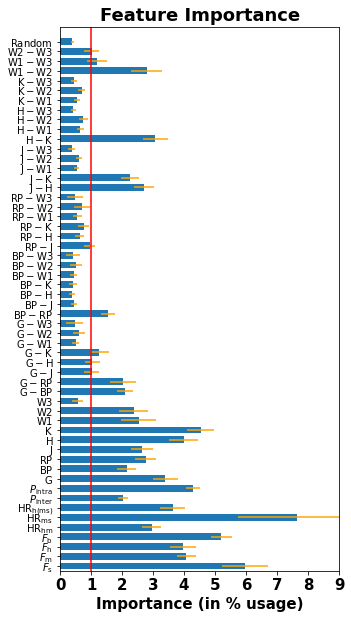

In [24]:
# confusion matrix
recall_cm = plot_confusion_matrix(pd.read_csv('../../files/LOO_classes.csv'),classes=class_labels,title='Norm. Confusion Matrix (%)',width=450,height=400)
show(recall_cm)

# feature importance
feaimps = pd.read_csv('../../files/feature_importance.csv')
fea_imp = plot_Feature_Importance_withSTD(feaimps.iloc[0], feaimps.iloc[1],feaimps.columns,400,800)


### XCLASS interactive plotting website of TD overplotted with field data 

https://home.gwu.edu/~kargaltsev/XCLASS/

* click on Choose File and upload {dir_out}/{field_name}_XCLASS.csv to overplot the field data


#### Visualizing the classification matrix
The classification matrix shows the probability array (the probability to be classified to 8 classes of X-ray emitters from TD) in each row for each source in the field 

In [38]:
# the sources to plot the classification matrix can be defined by users

# this example plots the top 2 least confidently classified sources and top 3 most confidently classified sources
df_class_matrix = field_mw_class[field_mw_class.CT>0].sort_values(by=['CT'])
df_class_matrix = pd.concat([df_class_matrix.head(2), df_class_matrix.tail(3)])

plot_class_matrix(field_name, df_class_matrix, dir_plot, class_labels)

#### The histograms of all and confident classifications 

In [146]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# cut on significance
field_mw_class = field_mw_class.loc[field_mw_class['flux_significance_b_max']>5]
print(f'Number of sources with significance > 5: {len(field_mw_class)}')
field_mw_class['Class'].value_counts().plot(kind='bar', ax=ax1, title='All Classification')
field_mw_class[field_mw_class.CT>=CT_cut]['Class'].value_counts().plot(kind='bar', ax=ax2, title='Confident Classification')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig(f'{dir_plot}/{field_name}_class_results.png', dpi=300)


#### multi-band spectrum of TD overplotted with field data (in cyan)
* set plot_classes the classes of sources that you want to plot the broadband SEDs
* The fluxes are normalized so that the medium band fluxes are all the same
* The color indicates the density of the sources from the TD In the multi-band spectrum

In [18]:
TD.columns

Index(['name', 'ra', 'dec', 'PU', 'significance', 'Fcsc_s', 'e_Fcsc_s',
       'Fcsc_m', 'e_Fcsc_m', 'Fcsc_h', 'e_Fcsc_h', 'flux_aper90_ave_b',
       'e_flux_aper90_ave_b', 'var_intra_prob', 'var_inter_prob', 'CSC_flags',
       'EDR3Name_gaia', '_r_gaia', 'PU_gaia', 'RA_ICRS_gaia', 'DE_ICRS_gaia',
       'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'Plx',
       'e_Plx', 'PM', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo',
       'B_rpgeo', 'cp_flag_gaia', '_2MASS_2mass', '_r_2mass', 'PU_2mass',
       'RAJ2000_2mass', 'DEJ2000_2mass', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag',
       'Kmag', 'e_Kmag', 'cp_flag_2mass', 'Name_catwise', '_r_catwise',
       'PU_catwise', 'RA_ICRS_catwise', 'DE_ICRS_catwise', 'W1mag_catwise',
       'e_W1mag_catwise', 'W2mag_catwise', 'e_W2mag_catwise',
       'cp_flag_catwise', 'objID_unwise', '_r_unwise', 'PU_unwise',
       'RAJ2000_unwise', 'DEJ2000_unwise', 'W1mag_unwise', 'e_W1mag_unwise',
       'W2mag_unwise', 'e_W2mag_unwise', 'cp_flag_u

In [19]:
TD_mw = TD.rename(columns={'Fcsc_s':'F_s','Fcsc_m':'F_m','Fcsc_h':'F_h','flux_aper90_ave_b':'F_b',\
                            'Gmag':'G','BPmag':'BP','RPmag':'RP','Jmag':'J','Hmag':'H','Kmag':'K','W1mag':'W1','W2mag':'W2','W3mag':'W3',\
                            'var_intra_prob':'P_intra', 'var_inter_prob':'P_inter'})

In [54]:
plot_classes = ['YSO','LMXB','LM-STAR','NS','CV','AGN']
plotlist = [plot_bbsed(TD_mw, field_mw_class, dir_plot, plot_class=c, save_class=[], confidence=True, TD_name_col=False) for c in plot_classes]

layout = hv.Layout(plotlist).cols(3)

layout

#### prepare the event file and plot X-ray images with classification results overplotted (these images are saved in plot directory)

##### a ds9 window will pop up for data processing which can be ignored 

In [22]:
# this takes a few minutes up to an hour to run depending on how many ObsIDs are used for the field
if ciao:
    evt2_data,  fn_evt2 = prepare_evts_plot_xray_class(field_name, RA, DEC, radius, data_dir, dir_out)

bash: to_merge.sh: No such file or directory


#### plotting multi-band field images with ipyaladin 

In [55]:

aladin = ipyal.Aladin(target=str(RA)+' '+str(DEC), fov=radius/20)


dtb = QTable.from_pandas(field_mw_class[field_mw_class.conf_flag>0])

aladin

Aladin(fov=0.6, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [56]:
aladin.add_table(dtb)

#### Interactive plotting of X-ray image overplotted with classification results 

In [25]:
if ciao:
    interactive_Ximg_class(field_name, evt2_data, fn_evt2, dir_out, RA, DEC, radius,include_TD=True)

#interactive_Ximg_class(src, evt2_data, fn_evt2, src_dir,RA=df_single.loc[0, 'RA_ICRS'],DEC=df_single.loc[0, 'DE_ICRS'], radius=df_single.loc[0, 'PU_TeV'],include_TD=True)
        

## Q&A
* What kind of user interface would you like for the MUWCLASS pipeline? 
* Do you have any comments or suggestions that can help us improve the MUWCLASS pipeline?